<a href="https://colab.research.google.com/github/Matvej911/Matvejs_Aleksejevs_DLBAIPNLP01/blob/main/main_models_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, f1_score, roc_curve
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import logging


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from gensim.models import Word2Vec


from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Download required NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Load the dataset

In [ ]:
df1 = pd.read_csv('dataset_small_2.csv')
df2 = pd.read_csv('dataset_small_1.csv')

In [ ]:
df2.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df1.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### First Dataset Preparation

In [ ]:
df2['Message'] = df2['text']
df2['target'] = df2['label']
df2['message_len'] = df2['Message'].apply(lambda x: len(x.split()))  # Count words in each message
df2 = df2.drop(columns=['Unnamed: 0', 'label_num'])

# Select only the relevant columns in the specified order
df2 = df2[['target', 'Message', 'message_len']]
df2.head()

,target,Message,message_len
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,67
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",23
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",550
3,spam,"Subject: photoshop , windows , office . cheap ...",48
4,ham,Subject: re : indian springs\r\nthis deal is t...,70


#### Second Dataset Preparation

In [ ]:
df1['target'] = df1['Category']
df1['message_len'] = df1['Message'].apply(lambda x: len(x.split()))  # Count words in each message

df1 = df1[['target', 'Message', 'message_len']]
df1.head()


,target,Message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


#### Concatenating and Shuffling DataFrames

In [ ]:
# Concatenate dataframes df1 and df2
combined_df = pd.concat([df1, df2], ignore_index=True)

# Shuffle the combined dataframe
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)


#### Visualization of Class Distribution in the Dataset

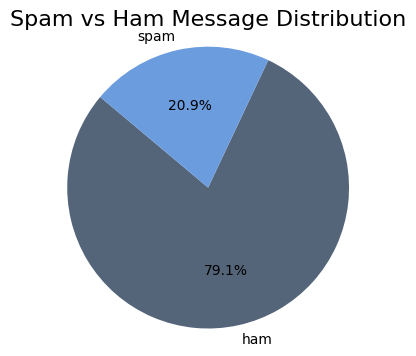

In [ ]:
balance_counts = df['target'].value_counts()

# Create a pie chart to visualize the class distribution
plt.figure(figsize=(4, 4))
plt.pie(balance_counts, labels=balance_counts.index, autopct='%1.1f%%', startangle=140, colors=['#54657a', '#6a9cde'])

plt.title('Spam vs Ham Message Distribution', fontsize=16)
plt.axis('equal')
plt.show()

#### Downsampling Ham Messages to Balance Dataset with Spam Messages

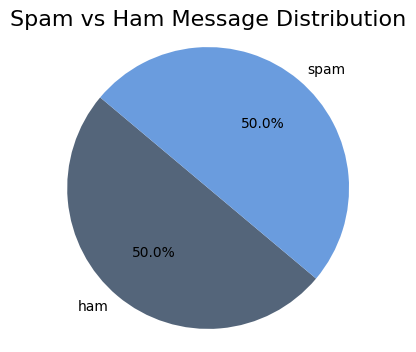

In [ ]:
# Count the number of 'spam' messages
num_spam = df[df['target'] == 'spam'].shape[0]

# Downsample 'ham' messages to match the number of 'spam' messages
ham_downsampled = df[df['target'] == 'ham'].sample(n=num_spam, random_state=42)

# Keep all 'spam' messages
spam_messages = df[df['target'] == 'spam']

# Combine downsampled 'ham' messages with 'spam' messages
df = pd.concat([ham_downsampled, spam_messages])

# Shuffle the resulting DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

balance_counts1 = df['target'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(balance_counts1, labels=balance_counts.index, autopct='%1.1f%%', startangle=140, colors=['#54657a', '#6a9cde'])

plt.title('Spam vs Ham Message Distribution', fontsize=16)
plt.axis('equal')
plt.show()


#### Length Distribution of Spam and Ham Messages
As we can see from the chart, ham messages tend to be shorter than spam messages.

In [ ]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color='#54657a',
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color='#6a9cde',
))
fig.update_layout(
    title='<span style="font-size:32px>Length Distribution of Spam and Ham Messages</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

#### Text Preprocessing for Spam Detection

In [ ]:
# Define a set of stop words
stop_words = set(stopwords.words('english'))

# Define a dictionary for shorthand expansions
abbreviations = {
    "$": "dollar",
    "€": "euro",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3": "anytime, anywhere, anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asap": "as soon as possible",
    "asl": "age, sex, location",
    "atk": "at the keyboard",
    "ave.": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b.c": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bae": "before anyone else",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "blvd": "boulevard",
    "bout": "about",
    "brb": "be right back",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "btw": "by the way",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "can't stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "diy": "do it yourself",
    "dm": "direct message",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fb": "facebook",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft.": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it's worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "g.o.a.t": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idc": "i don't care",
    "idgadf": "i don't give a damn fuck",
    "idgaf": "i don't give a fuck",
    "idk": "i don't know",
    "ie": "that is",
    "ifyp": "i feel your pain",
    "IG": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "lol": "laughing out loud",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mr": "mister",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "no big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omg": "oh my god",
    "omw": "on my way",
    "p.a": "per annum",
    "p.m": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "ppl": "people",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "que pasa?",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "retweet",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "smh": "shake my head",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbh": "to be honest",
    "tbs": "tablespoonful",
    "tbsp": "tablespoonful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "tho": "though",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long didn't read",
    "tldr": "too long didn't read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "ttfn": "ta-ta for now!",
    "ttyl": "talk to you later",
    "u": "you",
    "u2": "you too",
    "u4e": "yours forever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/e": "whatever",
    "w/o": "without",
    "w8": "wait",
    "wb": "welcome back",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping, bored, tired"
}

def expand_abbreviations(text):
    """Expand common abbreviations in the text."""
    for word, replacement in abbreviations.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)
    return text

def clean_message(text):
    """
    Clean the input text by:
    1. Converting to lowercase
    2. Removing text in square brackets
    3. Removing links
    4. Removing punctuation
    5. Removing words containing numbers
    6. Expanding abbreviations
    7. Removing stop words
    8. Removing extra whitespaces
    """
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    text = expand_abbreviations(text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_subject(text):
    return re.sub(r'Subject:', '', text, flags=re.IGNORECASE).strip()

df['cleaned_message'] = df['Message'].apply(remove_subject).apply(clean_message)

df['target'] = df['target'].map({'ham': 0, 'spam': 1})  # Encode labels

df.sample(5)


,target,Message,message_len,cleaned_message
1207,1,No 1 POLYPHONIC tone 4 ur mob every week! Just...,31,polyphonic tone ur mob every week txt tone fre...
664,1,Subject: re : milf neighbors lookin for . . . ...,65,milf neighbors lookin fbs e x local singles in...
1675,1,Customer service announcement. We recently tri...,24,customer service announcement recently tried m...
3294,1,"Subject: buy your medicines from us , viagra ,...",76,buy medicines us viagra xanax doctor visit nee...
4083,0,"Mmmmmm ... I love you,so much, Ahmad ... I can...",32,mmmmmm love youso much ahmad cant wait year be...


#### Comparative Analysis of Stemming and Lemmatization with Vectorization Techniques in Text Classification
By preprocessing cleaned messages through either stemming or lemmatization, the code assesses their effects on various machine learning models, including Naive Bayes, Logistic Regression, Support Vector Machine, and Random Forest.

In [ ]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

models = {
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier()
}

def preprocess_text(text, method='stemming'):
    """Preprocess the input text using stemming or lemmatization."""
    words = word_tokenize(text)
    if method == 'stemming':
        return ' '.join(stemmer.stem(word) for word in words)
    elif method == 'lemmatization':
        return ' '.join(lemmatizer.lemmatize(word) for word in words)

methods = ['stemming', 'lemmatization']
accuracies_bow = {}
accuracies_tfidf = {}

trained_models = {}

for method in methods:
    # Preprocess messages
    df['preprocessed_message'] = df['cleaned_message'].apply(lambda x: preprocess_text(x, method))

    # Split the data into features and labels
    X = df['preprocessed_message']
    y = df['target']

    # Define a function to evaluate a given vectorization method with multiple models
    def evaluate_vectorization(vectorizer, X, y, model):
        """Evaluate the performance of the vectorization method with the specified model."""
        X_vectorized = vectorizer.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        return accuracy, report

    # Evaluate different models with Bag of Words
    print(f"Evaluating Bag of Words with {method}...")
    count_vectorizer = CountVectorizer()

    # Loop through models for Bag of Words
    for model_name, model in models.items():
        accuracy_bow, report_bow = evaluate_vectorization(count_vectorizer, X, y, model)
        accuracies_bow[f'{model_name} - {method}'] = accuracy_bow
        trained_models[model_name] = model  # Store the trained model
        print(f"{model_name} - Bag of Words ({method}):")
        print(f'Accuracy: {accuracy_bow:.4f}')
        print('Classification Report:')
        print(report_bow)

    # Evaluate different models with TF-IDF
    print(f"Evaluating TF-IDF with {method}...")
    tfidf_vectorizer = TfidfVectorizer()

    # Loop through models again for TF-IDF
    for model_name, model in models.items():
        accuracy_tfidf, report_tfidf = evaluate_vectorization(tfidf_vectorizer, X, y, model)
        accuracies_tfidf[f'{model_name} - {method}'] = accuracy_tfidf
        trained_models[model_name] = model  # Store the trained model
        print(f"{model_name} - TF-IDF ({method}):")
        print(f'Accuracy: {accuracy_tfidf:.4f}')
        print('Classification Report:')
        print(report_tfidf)



Evaluating Bag of Words with stemming...
Naive Bayes - Bag of Words (stemming):
Accuracy: 0.9132
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       444
           1       0.89      0.94      0.92       455

    accuracy                           0.91       899
   macro avg       0.91      0.91      0.91       899
weighted avg       0.91      0.91      0.91       899

Support Vector Machine - Bag of Words (stemming):
Accuracy: 0.8554
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       444
           1       0.91      0.80      0.85       455

    accuracy                           0.86       899
   macro avg       0.86      0.86      0.86       899
weighted avg       0.86      0.86      0.85       899

Logistic Regression - Bag of Words (stemming):
Accuracy: 0.9321
Classification Report:
              precision    recall  f1-score   sup

#### Comparison of Model Accuracies Using Bag of Words and TF-IDF Vectorization Techniques
This visualization compares the accuracy of various machine learning models when using two different text vectorization techniques: Bag of Words and TF-IDF. The accuracy values for each model are displayed as bars, with percentage values annotated on top for clarity. The models are evaluated with both stemming and lemmatization preprocessing methods

In [ ]:
print("Bag of Words Accuracies Keys:", accuracies_bow.keys())
print("TF-IDF Accuracies Keys:", accuracies_tfidf.keys())


Bag of Words Accuracies Keys: dict_keys(['Naive Bayes - stemming', 'Support Vector Machine - stemming', 'Logistic Regression - stemming', 'Random Forest - stemming', 'Naive Bayes - lemmatization', 'Support Vector Machine - lemmatization', 'Logistic Regression - lemmatization', 'Random Forest - lemmatization'])
TF-IDF Accuracies Keys: dict_keys(['Naive Bayes - stemming', 'Support Vector Machine - stemming', 'Logistic Regression - stemming', 'Random Forest - stemming', 'Naive Bayes - lemmatization', 'Support Vector Machine - lemmatization', 'Logistic Regression - lemmatization', 'Random Forest - lemmatization'])


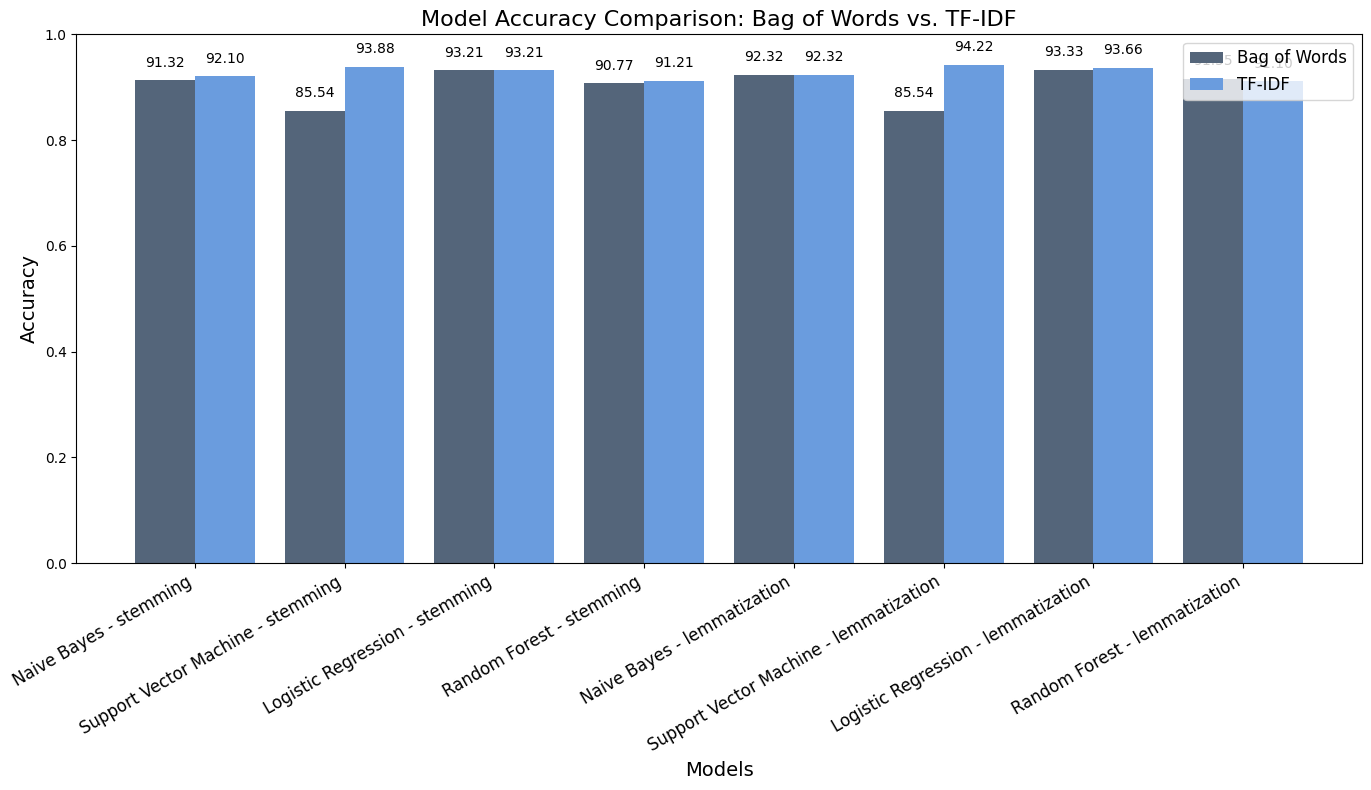

In [ ]:
# Visualization of accuracies
labels = list(models.keys())
bow_accuracies = [accuracies_bow[f'{model_name} - stemming'] for model_name in labels] + \
                 [accuracies_bow[f'{model_name} - lemmatization'] for model_name in labels]
tfidf_accuracies = [accuracies_tfidf[f'{model_name} - stemming'] for model_name in labels] + \
                   [accuracies_tfidf[f'{model_name} - lemmatization'] for model_name in labels]


x = range(len(labels) * 2)
plt.figure(figsize=(14, 8))


bars_bow = plt.bar(x, bow_accuracies, width=0.4, label='Bag of Words', color='#54657a', align='center')
bars_tfidf = plt.bar([p + 0.4 for p in x], tfidf_accuracies, width=0.4, label='TF-IDF', color='#6a9cde', align='center')

# Adding percentage values on top of the bars with two decimal places
for bar in bars_bow:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval * 100:.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars_tfidf:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval * 100:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Comparison: Bag of Words vs. TF-IDF', fontsize=16)
plt.xticks([p + 0.2 for p in x],
           [f"{model} - stemming" for model in labels] +
           [f"{model} - lemmatization" for model in labels],
           rotation=30, ha='right', fontsize=12)
plt.ylim(0, 1)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


#### Interactive Spam Classifier: Logging Predictions with Selected Models

In [ ]:
logging.basicConfig(filename='spam_prediction_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

def predict_spam(model_name, message, vectorizer):
    """Predict if a message is spam using the specified model."""
    vectorized_message = vectorizer.transform([preprocess_text(message, 'stemming')])
    prediction = trained_models[model_name].predict(vectorized_message)
    return "Spam" if prediction[0] == 1 else "Not Spam"

def main():
    print("Choose a model for prediction:")
    for idx, model_name in enumerate(trained_models.keys(), 1):
        print(f"{idx}. {model_name}")

    choice = int(input("Enter the model number: ")) - 1
    model_name = list(trained_models.keys())[choice]

    logging.info(f"Selected Model: {model_name}")

    message = input("Enter the message to classify: ")

    # Log the message input
    logging.info(f"Message Entered: {message}")

    result = predict_spam(model_name, message, vectorizer)

    # Log the prediction result
    logging.info(f"Prediction Result: {result}")

    print(f"The message is classified as: {result}")

if __name__ == "__main__":
    main()


Choose a model for prediction:
1. Naive Bayes
2. Support Vector Machine
3. Logistic Regression
4. Random Forest
Enter the model number: 1
Enter the message to classify: How are you Mike?
The message is classified as: Not Spam


#### Classification Using Word2Vec Embeddings and Neural Network
 Initially, the cleaned text data is tokenized and padded to ensure uniform input size. A Word2Vec model is then trained on the tokenized texts to create word embeddings, which capture semantic relationships between words. An embedding matrix is constructed to incorporate these pretrained embeddings into a neural network model. The model consists of an embedding layer (initialized with the Word2Vec embeddings), followed by a flattening layer and dense layers for binary classification.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



1797/1797 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - accuracy: 0.7872 - loss: 0.5065 - val_accuracy: 0.8877 - val_loss: 0.2921
Epoch 2/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.8876 - loss: 0.2765 - val_accuracy: 0.8888 - val_loss: 0.3169
Epoch 3/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9010 - loss: 0.2397 - val_accuracy: 0.8865 - val_loss: 0.3554
Epoch 4/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - accuracy: 0.9092 - loss: 0.2213 - val_accuracy: 0.8732 - val_loss: 0.3726
Epoch 5/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 142s 52ms/step - accuracy: 0.9211 - loss: 0.1814 - val_accuracy: 0.8621 - val_loss: 0.3680
Epoch 6/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 141s 51ms/step - accuracy: 0.9301 - loss: 0.1736 - val_accuracy: 0.8643 - val_loss: 0.4764
Epoch 7/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 90s 50ms/step - accuracy: 0.9338 - loss: 0.1702 - val_accuracy: 0.8498 - val_loss: 0.5563
Epoch 8/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 144s 51ms/step - accuracy: 0.9395 - loss: 0

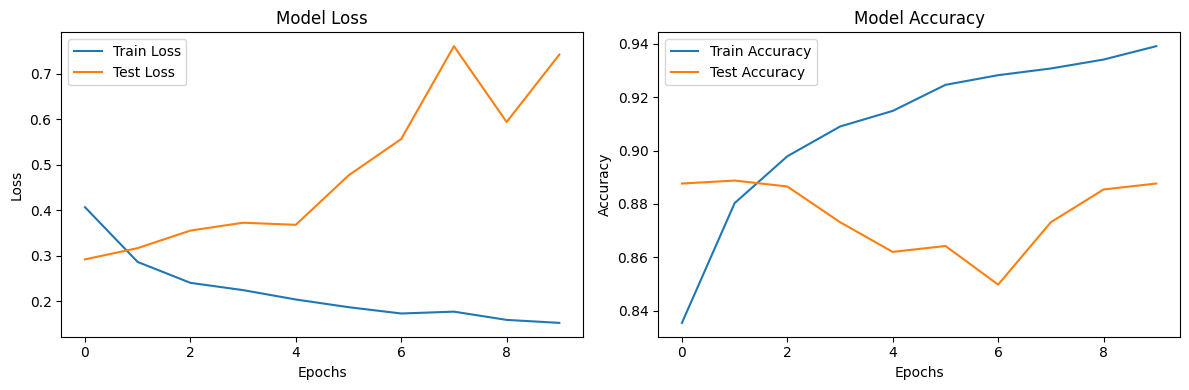

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_message'])
sequences = tokenizer.texts_to_sequences(df['cleaned_message'])
X = pad_sequences(sequences)
y = df['target'].values

# Train Word2Vec model
tokenized_texts = [word_tokenize(text) for text in df['cleaned_message']]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]  #

# Define neural network with pretrained Word2Vec embeddings
def create_model(vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = create_model(vocab_size, embedding_dim, embedding_matrix)
history = model.fit(X_train, y_train, epochs=10, batch_size=2, verbose=1, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()




#### Modified Deep Learning Model for Spam Detection

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.6373 - loss: 0.7776 - val_accuracy: 0.8532 - val_loss: 0.3820
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.7408 - loss: 0.5646 - val_accuracy: 0.8799 - val_loss: 0.3582
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8074 - loss: 0.5443 - val_accuracy: 0.8754 - val_loss: 0.3373
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.8192 - loss: 0.4232 - val_accuracy: 0.8788 - val_loss: 0.3539
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.8265 - loss: 0.4463 - val_accuracy: 0.8799 - val_loss: 0.3233
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.8369 - loss: 0.4145 - val_accuracy: 0.8331 - val_loss: 0.3674
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.8384 - loss: 0.3831 - val_accuracy: 0.8799 - val_loss: 0.3131
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.8418 - loss: 0

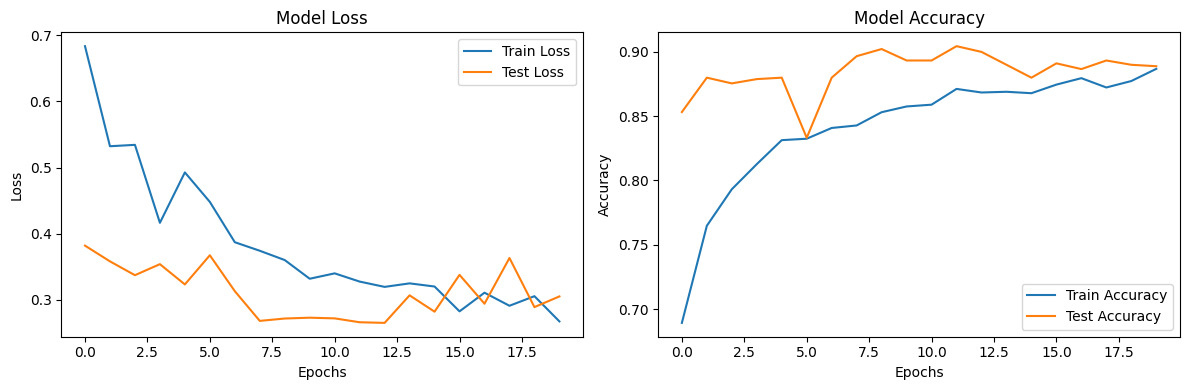

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_message'])
sequences = tokenizer.texts_to_sequences(df['cleaned_message'])
X = pad_sequences(sequences)
y = df['target'].values

# Train Word2Vec model
tokenized_texts = [word_tokenize(text) for text in df['cleaned_message']]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Define neural network with pretrained Word2Vec embeddings
def create_model(vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))  # Increased neurons
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(16, activation='relu'))  # Additional hidden layer
    model.add(Dropout(0.5))  # Another Dropout layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = create_model(vocab_size, embedding_dim, embedding_matrix)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()